In [29]:
import pandas as pd
import numpy as np
import scanpy as sc

from matplotlib import pyplot as plt

import seaborn as sns

sns.set_theme("paper")
sns.set_style("whitegrid")

## Run Pypsupertime

In [5]:
from pypsupertime import Psupertime

psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False,
                                          "smooth": False, "select_genes": "all"},
                    estimator_params={"max_iter": 75},
                    n_jobs=4,
                    n_batches=1)
adata = psuper.run("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad", "donor_age")

Input Data: n_genes=23368, n_cells=411
Preprocessing: done. mode='all', n_genes=13564, n_cells=411
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.545012.02, n_genes=94
Total elapsed time:  0:42:46.341198


In [49]:
psuper.refit_and_predict(adata, "best")

Input Data: n_genes=13564, n_cells=411
Refit on all data: done. accuracy=0.832117.02, n_genes=248


Best idx: 23 Best Score: 0.6424919188950926 Best Lambda: 0.004375479375074184 Scores std: 0.17359400458099286
1SE idx: 18 1SE Score: 0.5134880987364091 1SE Lambda: 0.014251026703029985


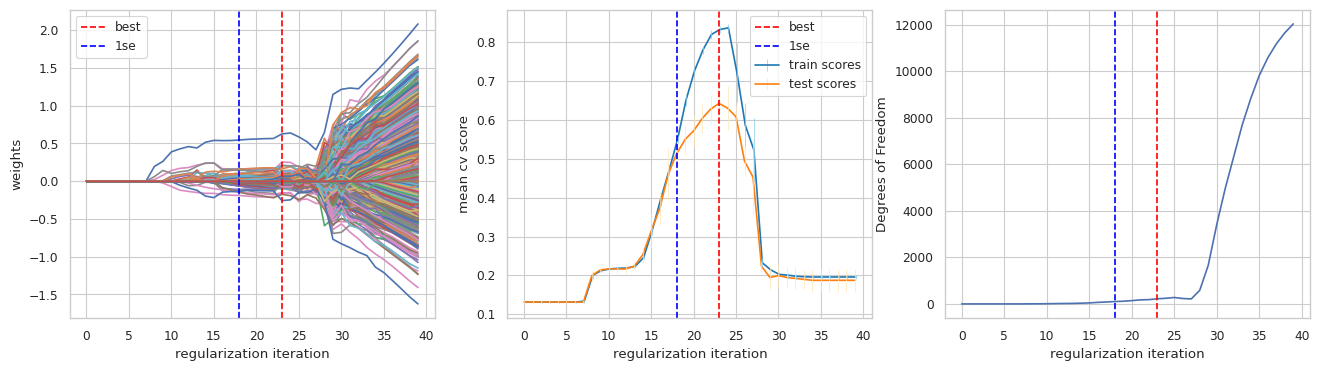

In [33]:
fig = psuper.plot_grid_search(title="")
fig.savefig("figures/plot_grid_search_all_genes.png")

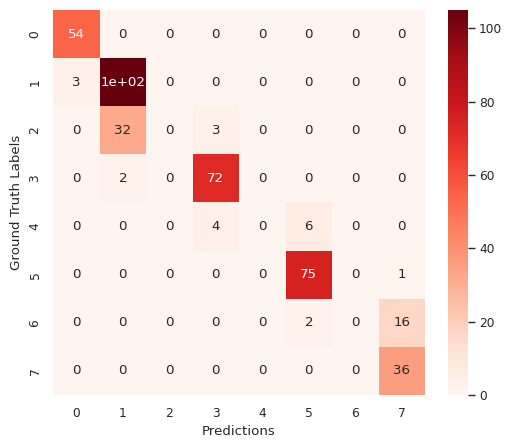

In [50]:
from sklearn import metrics
from pypsupertime.preprocessing import transform_labels

X = adata.X
y_trans = adata.obs.ordinal_label

cmap_seq = sns.color_palette("Reds", as_cmap=True)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
sns.heatmap(metrics.confusion_matrix(y_trans, psuper.model.predict(X)), cmap=cmap_seq, annot=True, ax=ax)
ax.set_ylabel("Ground Truth Labels")
ax.set_xlabel("Predictions")

fig.savefig("figures/plot_predictions.png")

**Training success and the binary training paradigm produces the exact same parameters as the multi-class wrapper, given the same data and seed.**

## Genes Python

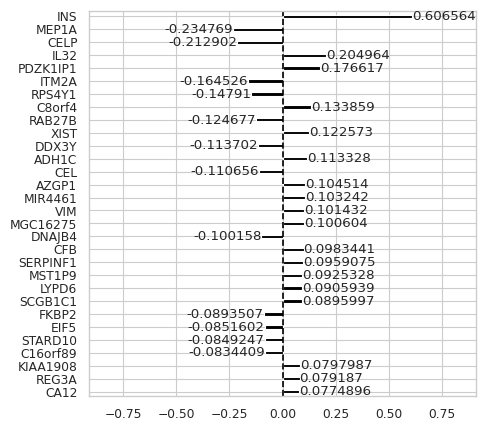

In [51]:
fig = psuper.plot_identified_gene_coefficients(adata, n_top=30, figsize=(5,5))
fig.savefig("figures/plot_gene_coefficients.png")

![Psupertime predictions against class labels](Acinar_R_ConfusionMatrix.png)

Text(0.5, 0.98, 'Regularization Grid Search (in R)')

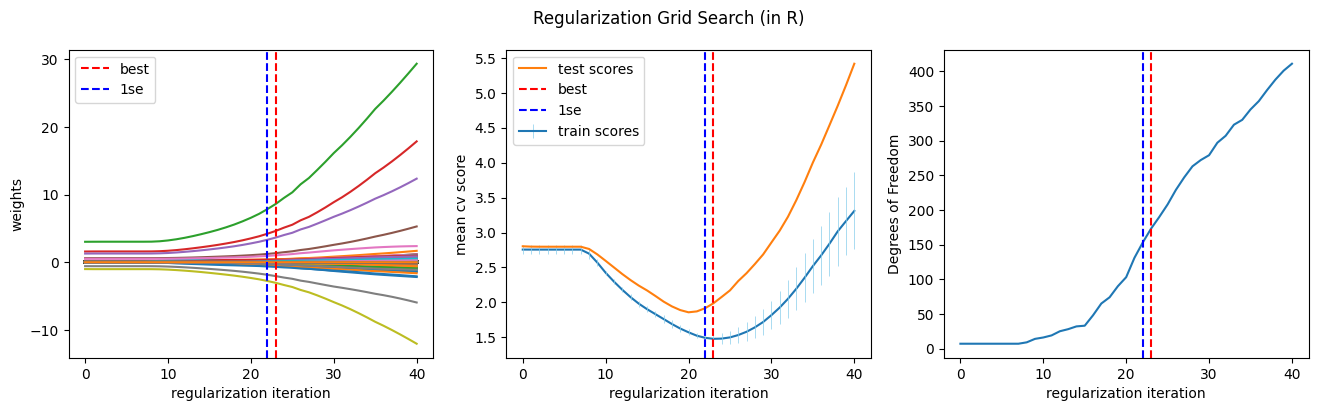

In [7]:
from matplotlib import pyplot as plt

# model weights and degrees of freedom
training_weights_r = pd.read_csv("../03_Acinar_R_analysis/weights.csv")
weights_list_r = list(training_weights_r.iloc[:,1:].to_numpy().T)
dof_r = [sum(np.array(w) != 0) for w in weights_list_r]

train_res_r = pd.read_csv("../03_Acinar_R_analysis/train_scores.csv")
test_res_r = pd.read_csv("../03_Acinar_R_analysis/test_scores.csv")


n_folds = 5
x = np.arange(len(train_res_r["lambda"].unique().flatten()))

best_idx = 23
ose_idx = 22

test_scores = test_res_r["score_val"].to_numpy()
train_scores = np.reshape(train_res_r["score_val"], (len(x), n_folds), "F")
train_means = train_scores.mean(axis=1)
train_stds = train_scores.std(axis=1)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(131)
ax1.plot(weights_list_r)
ax1.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax1.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax1.set_xlabel("regularization iteration")
ax1.set_ylabel("weights")
#ax1.set_yscale("log")
ax1.legend()

ax3 = fig.add_subplot(132)
ax3.errorbar(x=x, y=train_means, yerr=train_stds, elinewidth=0.5, color="tab:blue", ecolor="skyblue", barsabove=True, label="train scores")
ax3.plot(x, test_scores, color="tab:orange", label="test scores")
ax3.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax3.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax3.set_xlabel("regularization iteration")
ax3.set_ylabel("mean cv score")
ax3.legend()

ax2 = fig.add_subplot(133)
 
ax2.plot(dof_r)
ax2.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax2.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax2.set_xlabel("regularization iteration")
ax2.set_ylabel("Degrees of Freedom")

fig.suptitle("Regularization Grid Search (in R)")

**Training seems plausible. Overfitting also in the original work. NOTE: As can be seen from the best and 1se index selected by (R-)psupertime, the "best score" and "next score" are determined based on the _training_ performance, not the validation split!**

## R results

```
> pobj <- psupertime::psupertime(acinar_sce,
+                                  acinar_sce$donor_age,
+                                  smooth=FALSE,
+                                  min_expression = 0.01,
+                                  scale=TRUE,
+                                  sel_genes="all", penalization='1se')
> paste(pobj$beta_dt[pobj$beta_dt$abs_beta != 0]$symbol, collapse="', '")
[1] "INS', 'CELP', 'IL32', 'VIM', 'RPS4Y1', 'SERPINF1', 'C8orf4', 'ITM2A', 'PDZK1IP1', 'FKBP2', 'MEP1A', 'SELM', 'RXRB', 'MUC1', 'ELF3', 'DNASE1', 'HSPA5', 'CA12', 'REG3A', 'HSPH1', 'AKR1C3', 'CFB', 'ACADSB', 'AZGP1', 'TMEM41A', 'TSPO', 'GPR133', 'HSPG2', 'EIF5', 'STARD10', 'PGM2L1', 'ITGAV', 'UNC5CL', 'REG4', 'NGFRAP1', 'FGL1', 'BACE2', 'NDUFS5', 'PCNXL3', 'CEL', 'MLL', 'RAB27B', 'DDX3Y', 'SERF2.C15ORF63', 'AQP12A', 'PARM1', 'LPCAT4', 'ZC3H7B', 'ABHD5', 'CCDC84', 'NOL3', 'LYPD6', 'SPR', 'GDF15', 'LOC728175', 'MGC16275', 'LOC145783', 'MFSD12', 'ZFAND5', 'FBXO32', 'ERBB2', 'UBA7', 'CLPSL1', 'ENTPD8', 'CCDC88C', 'SLC39A14', 'PM20D1', 'DDIT4', 'MIR4461', 'SCGB1C1', 'DNAJB4', 'COQ9', 'APOL6', 'ADH1C', 'NOTCH4', 'PRDX1', 'GCG', 'TICAM1', 'UBA3', 'SIK2', 'RPL13', 'STK25', 'CRIPT', 'HOMER2', 'TNFAIP3', 'LGALS3BP', 'SUMF1', 'RNU12', 'TOB1', 'BOD1', 'SERPINA3', 'IFRD1', 'FOXK2', 'PPARA', 'USP9X', 'C12orf39', 'SRSF7', 'CHCHD1', 'MKL1', 'DDB2', 'NR1H3', 'MAOA', 'PDK2', 'IKBKB', 'BAZ1B', 'GSTT1', 'COMMD7', 'GPR135', 'HSP90AA1', 'SYNRG', 'RNF213', 'ZHX1.C8ORF76', 'ZFAND2A', 'PRAF2', 'TAX1BP3', 'CDCA8', 'CRADD', 'CPNE7', 'TPM2', 'FBXL14', 'BCL11A', 'FILIP1', 'EFEMP2', 'TTN', 'MGC72080', 'MST1P9', 'C16orf89', 'YME1L1', 'GSTO1', 'IGFBP2', 'RASSF7', 'METTL1', 'CLDND1', 'AMY2B', 'HYOU1', 'INTS6', 'TCF4', 'FBL', 'RAD17', 'GABBR1', 'TMEM234', 'MDK', 'GRB10', 'TSC22D1', 'ZFPL1', 'PSAT1', 'CXCL2', 'WDR6', 'PUM2', 'LAMA3"
> balanced_accuracy(as.integer(pobj$proj_dt$label_input), as.integer(pobj$proj_dt$label_psuper))
[1] 0.5878905
> accuracy(as.integer(pobj$proj_dt$label_input), as.integer(pobj$proj_dt$label_psuper))
[1] 0.8004866
> mean_abs_error(as.integer(pobj$proj_dt$label_input), as.integer(pobj$proj_dt$label_psuper))
[1] 0.2506083
> pobj$best_dt
     score_var best_lambda next_lambda best_idx next_idx
1: class_error 0.012589254  0.01258925       20       20
2:    xentropy 0.006309573  0.01000000       23       21
> pobj
psupertime object using 411 cells * 23368 genes as input
    label ordering used for training: 1, 5, 6, 21, 22, 38, 44, 54
    genes selected for input: all
    # genes taken forward for training: 13564
    # genes identified as relevant: 150 (= 1% of training genes)
    mean training accuracy: 68%
    mean test accuracy: 56%
```

## Extract Genes

In [9]:
adata.var.psupertime_weight

1/2-SBSRNA4    0.0
A1BG           0.0
A1CF           0.0
A2LD1          0.0
A2M            0.0
              ... 
ZYG11B         0.0
ZYX            0.0
ZZEF1          0.0
ZZZ3           0.0
tAKR           0.0
Name: psupertime_weight, Length: 13564, dtype: float32

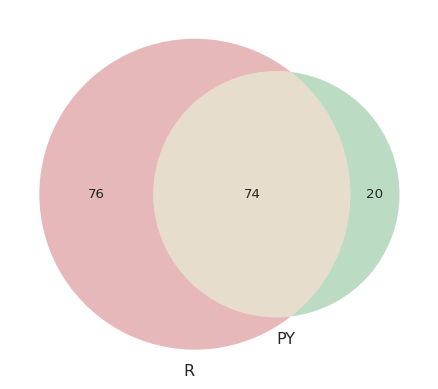

In [52]:
genes_py = adata.var_names[adata.var.psupertime_weight != 0]
genes_r = ['INS', 'CELP', 'IL32', 'VIM', 'RPS4Y1', 'SERPINF1',
           'C8orf4', 'ITM2A', 'PDZK1IP1', 'FKBP2', 'MEP1A',
           'SELM', 'RXRB', 'MUC1', 'ELF3', 'DNASE1', 'HSPA5',
           'CA12', 'REG3A', 'HSPH1', 'AKR1C3', 'CFB', 'ACADSB',
           'AZGP1', 'TMEM41A', 'TSPO', 'GPR133', 'HSPG2', 'EIF5',
           'STARD10', 'PGM2L1', 'ITGAV', 'UNC5CL', 'REG4',
           'NGFRAP1', 'FGL1', 'BACE2', 'NDUFS5', 'PCNXL3',
           'CEL', 'MLL', 'RAB27B', 'DDX3Y', 'SERF2.C15ORF63',
           'AQP12A', 'PARM1', 'LPCAT4', 'ZC3H7B', 'ABHD5',
           'CCDC84', 'NOL3', 'LYPD6', 'SPR', 'GDF15', 'LOC728175',
           'MGC16275', 'LOC145783', 'MFSD12', 'ZFAND5', 'FBXO32',
           'ERBB2', 'UBA7', 'CLPSL1', 'ENTPD8', 'CCDC88C',
           'SLC39A14', 'PM20D1', 'DDIT4', 'MIR4461', 'SCGB1C1',
           'DNAJB4', 'COQ9', 'APOL6', 'ADH1C', 'NOTCH4', 'PRDX1',
           'GCG', 'TICAM1', 'UBA3', 'SIK2', 'RPL13', 'STK25', 'CRIPT',
           'HOMER2', 'TNFAIP3', 'LGALS3BP', 'SUMF1', 'RNU12', 'TOB1',
           'BOD1', 'SERPINA3', 'IFRD1', 'FOXK2', 'PPARA', 'USP9X',
           'C12orf39', 'SRSF7', 'CHCHD1', 'MKL1', 'DDB2', 'NR1H3',
           'MAOA', 'PDK2', 'IKBKB', 'BAZ1B', 'GSTT1', 'COMMD7',
           'GPR135', 'HSP90AA1', 'SYNRG', 'RNF213', 'ZHX1.C8ORF76',
           'ZFAND2A', 'PRAF2', 'TAX1BP3', 'CDCA8', 'CRADD', 'CPNE7',
           'TPM2', 'FBXL14', 'BCL11A', 'FILIP1', 'EFEMP2', 'TTN',
           'MGC72080', 'MST1P9', 'C16orf89', 'YME1L1', 'GSTO1', 'IGFBP2',
           'RASSF7', 'METTL1', 'CLDND1', 'AMY2B', 'HYOU1', 'INTS6',
           'TCF4', 'FBL', 'RAD17', 'GABBR1', 'TMEM234', 'MDK', 'GRB10',
           'TSC22D1', 'ZFPL1', 'PSAT1', 'CXCL2', 'WDR6', 'PUM2', 'LAMA3']

# Fix symbol replacement done in R version
genes_r = [s.replace(".", "-") for s in genes_r]

from matplotlib_venn import venn2, venn2_circles
diagr = venn2([set(genes_r), set(genes_py)], set_labels=("R", "PY"))
plt.savefig("figures/plot_venn.png")

## Compare based on Clustermap

In [14]:
import scanpy as sc
import os

# Union and intersect of the identified genes
union = list(set(genes_py).union(set(genes_r)))
intersect = list(set(genes_py).intersection(set(genes_r)))

filename = "/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad"
acinar_raw = sc.read_h5ad(filename)

counts = acinar_raw[:,union].copy()

# Add a column indicating from which tool a gene was called
counts.var["group"] = None
counts.var.loc[genes_py, "group"] = "PY"
counts.var.loc[genes_r, "group"] = "R"
counts.var.loc[intersect, "group"] = "PY,R"

/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


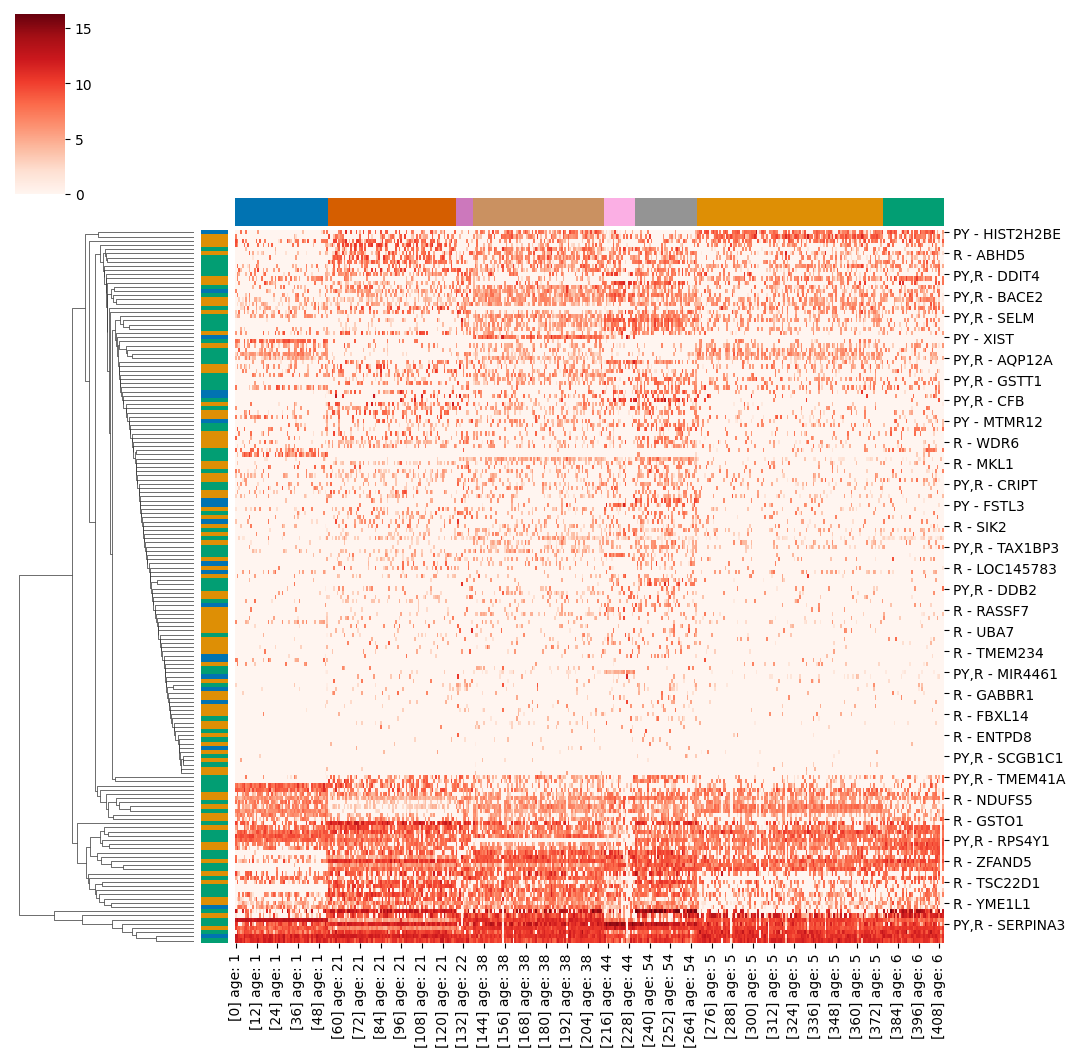

In [18]:
from pypsupertime.preprocessing import transform_labels
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns

# color palette
cmap_seq = sns.color_palette("Reds", as_cmap=True)

col_labels = transform_labels(counts.obs.donor_age.to_numpy())
cmap = sns.color_palette("colorblind", max(3, len(np.unique(col_labels))))

# row and column colors based on group and ordinal cell label
col_colors = [cmap[int(e)] for e in col_labels]
row_colors = [cmap[0 if e == "PY" else 1 if e == "R" else 2] for e in counts.var["group"].to_numpy()]

g = sns.clustermap(counts.X.T, cmap=cmap_seq, col_cluster=False, col_colors=col_colors, row_colors=row_colors)
ordering = g.dendrogram_row.reordered_ind

ylabels = []
# iterate only over the ticks that are plotted!
for text in g.ax_heatmap.get_yticklabels():
    # the Text() object contains the row index as a string
    i = int(text.get_text())
    group = counts.var.iloc[i].group
    gene_name = counts.var.iloc[i].name
    label = "%s - %s" % (group, gene_name)
    ylabels.append(label)
g.ax_heatmap.set_yticklabels(ylabels, rotation=0)

xlabels = []
# iterate only over the ticks that are plotted!
for text in g.ax_heatmap.get_xticklabels():
    # the Text() object contains the row index as a string
    i = int(text.get_text())
    time_label = counts.obs.iloc[i].donor_age
    label = "[%s] age: %s" % (i, time_label)
    xlabels.append(label)
g.ax_heatmap.set_xticklabels(xlabels, rotation=90)

# Display the plot
plt.show()

In [19]:
cmap_diverging = sns.diverging_palette(220, 20, as_cmap=True, center="light")

/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


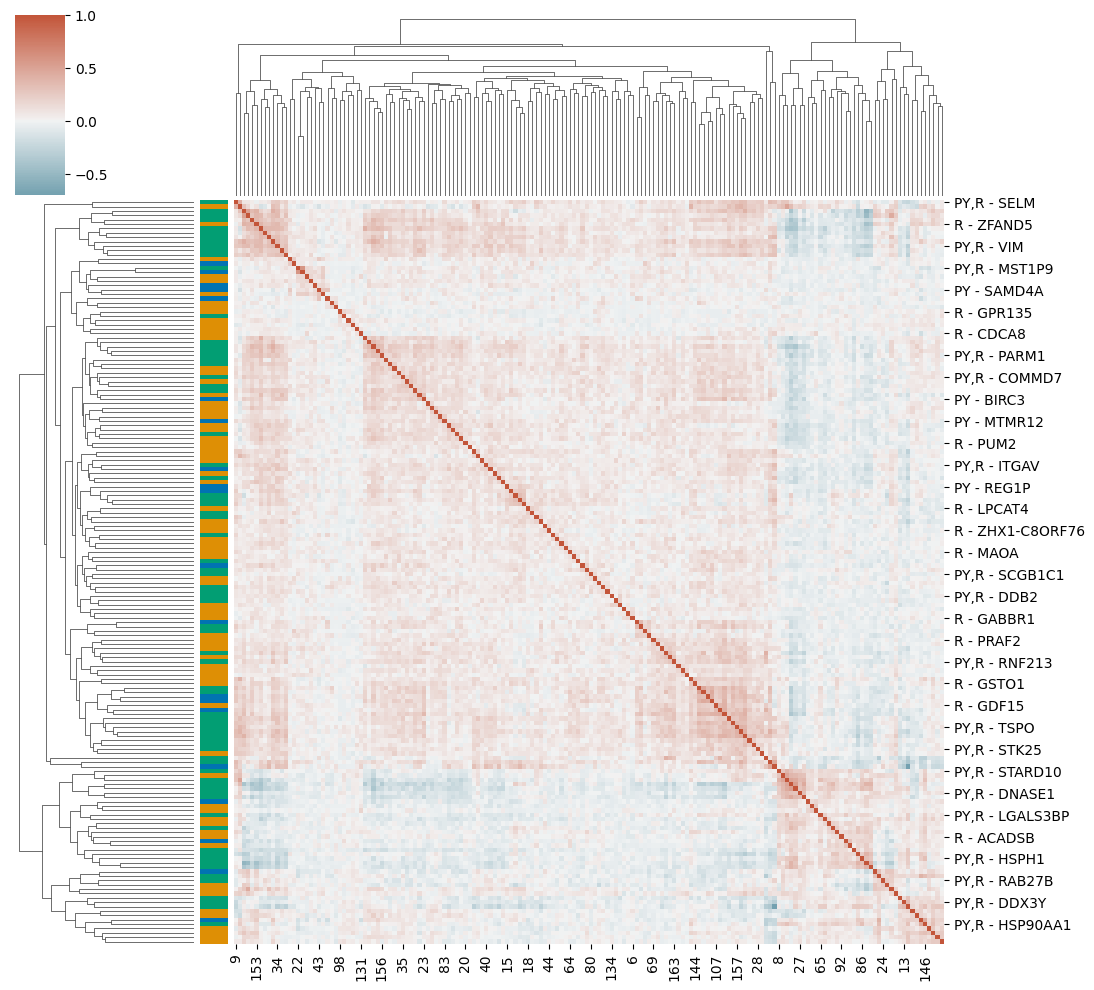

In [20]:
g = sns.clustermap(np.corrcoef(counts.X.T), center=0.0, cmap=cmap_diverging, col_cluster=True, row_colors=row_colors)

ylabels = []
# iterate only over the ticks that are plotted!
for text in g.ax_heatmap.get_yticklabels():
    # the Text() object contains the row index as a string
    i = int(text.get_text())
    group = counts.var.iloc[i].group
    gene_name = counts.var.iloc[i].name
    label = "%s - %s" % (group, gene_name)
    ylabels.append(label)
_ = g.ax_heatmap.set_yticklabels(ylabels, rotation=0)

## Compare to hierarchical clusters

In [21]:
import scanpy as sc
sc.tl.pca(adata, n_comps=4)

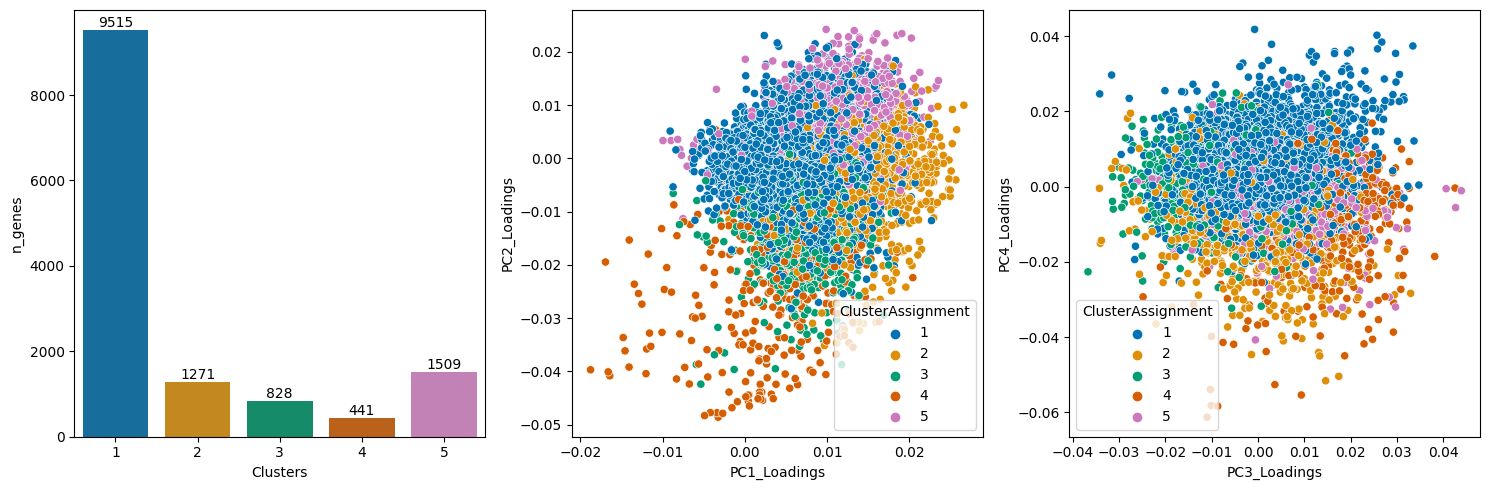

In [22]:
from scipy.cluster.hierarchy import linkage, fcluster

# calculate complete linkage on gene level
gene_linkage = linkage(adata.X.T, method="complete")

n_clusters = 5
flat_cluster_assignment = fcluster(gene_linkage, t=n_clusters, criterion="maxclust")

d = pd.DataFrame.from_dict({
        "PC1_Loadings": adata.varm["PCs"][:,0], 
        "PC2_Loadings": adata.varm["PCs"][:,1],
        "PC3_Loadings": adata.varm["PCs"][:,2], 
        "PC4_Loadings": adata.varm["PCs"][:,3],
        "ClusterAssignment": flat_cluster_assignment
    })

uq, cts = np.unique(flat_cluster_assignment, return_counts=True)
d2 = pd.DataFrame.from_dict({
        "Clusters": uq,
        "n_genes": cts
})

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5), sharex=False, sharey=False)

palette = cmap[:len(uq)]
sns.barplot(d2, x="Clusters", y="n_genes", ax=ax1, palette=palette)
ax1.bar_label(ax1.containers[0])
sns.scatterplot(d, x="PC1_Loadings", y="PC2_Loadings", hue="ClusterAssignment", ax=ax2, palette=palette)
sns.scatterplot(d, x="PC3_Loadings", y="PC4_Loadings", hue="ClusterAssignment", ax=ax3, palette=palette)

plt.tight_layout()

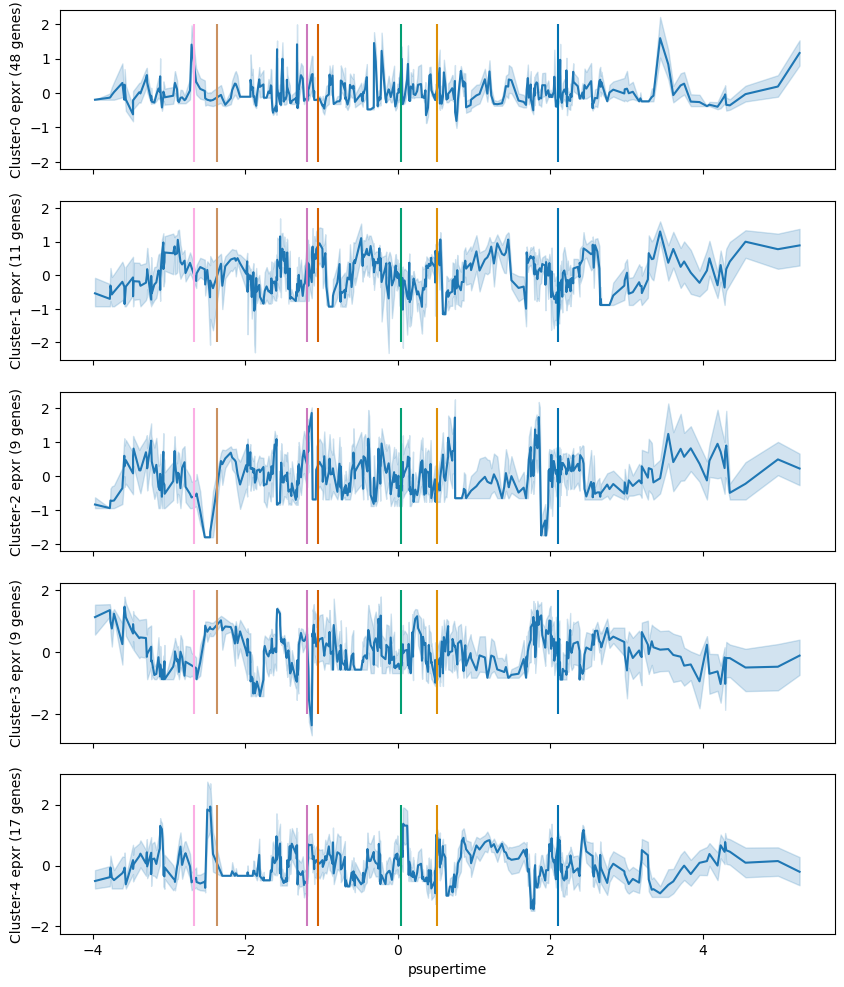

In [23]:
# calculate psupertime

genes_in_cluster = [list(adata.var.index[flat_cluster_assignment == c]) for c in uq]

# plot the expression for each cluster over psupertime
fig, axes = plt.subplots(nrows=n_clusters, ncols=1, sharex=True, sharey=False, figsize=(10, 12))
idx_sorted = np.argsort(adata.obs.psupertime.to_numpy())

for i in range(n_clusters):
    _genes = list(set(genes_py).intersection(set(genes_in_cluster[i]))) # genes_in_cluster[i] #
    d = pd.DataFrame(adata[:, _genes].X[idx_sorted,:], columns=_genes)
    d = d.melt(var_name="Gene", value_name="normalized_expression")
    d["psupertime"] = adata.obs["psupertime"][idx_sorted].repeat(len(_genes)).to_numpy()
    d["Cluster"] = i

    ax = axes[i]
    #sns.lineplot(d, x="psupertime", y="normalized_expression", ax=ax)
    sns.lineplot(d, x="psupertime", y="normalized_expression", ax=ax)
    #sns.lmplot(d, x="psupertime", y="normalized_expression", lowess=True)
    
    ax.vlines(psuper.model.intercept_,
              ymin=-2,#ymin=np.min(d["normalized_expression"]),
              ymax=2,#ymax=np.max(d["normalized_expression"]),
              colors=cmap)
    
    #ax.set_xlim((-50, 30))
    ax.set_ylabel("Cluster-%s epxr (%s genes)" % (i, len(_genes)))

**Cell orderings bad?**

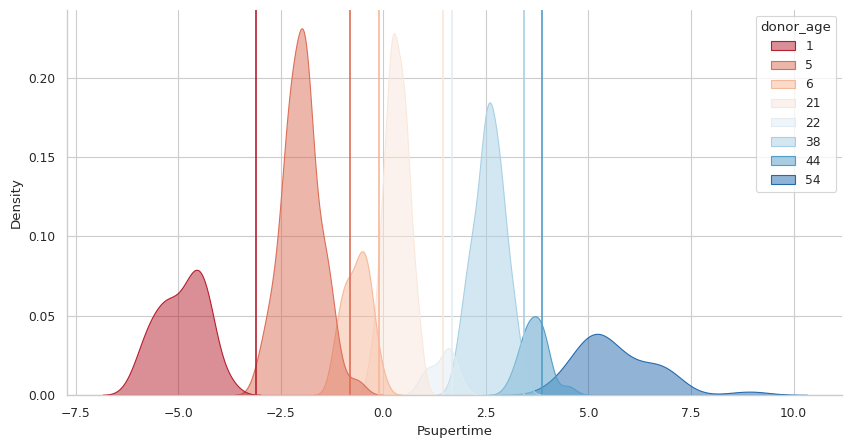

In [53]:
fig = psuper.plot_labels_over_psupertime(adata, "donor_age")
fig.savefig("figures/plot_labels_over_psupertime.png")

## Inspect Clustered Gene Expression

**TODO/Issue: Not the PCA Clusters but PCA _Loadings_ are considered below! Do again with PCA on gene dimension.**

In [25]:
background_genes_key = "unselected"
adata.var["group"] = counts.var.group
adata.var.group = adata.var.group.fillna(background_genes_key)

In [26]:
# Calculate PCA embedding with scanpy
#import scanpy as sc
#sc.tl.pca(acinar_sce, n_comps=4)
# -> only does PCA on cells and reports gene loadings

# Calculate PCA with sklearn -> uses second dimension by default
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(adata.X)
pca.components_.shape

(4, 13564)

Text(0.5, 0, 'Principle Component')

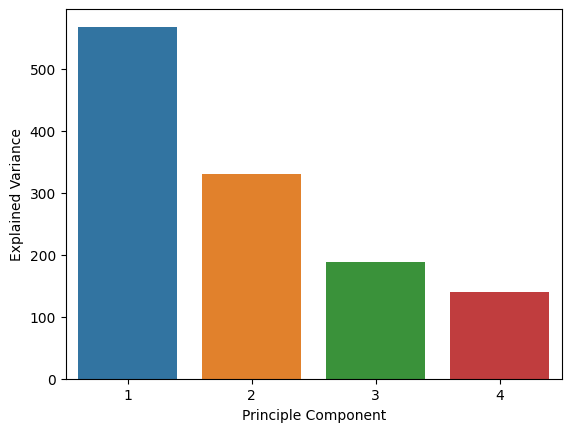

In [27]:
d = pd.DataFrame.from_dict({
        "Explained_Variance": pca.explained_variance_,
        "Principal_Component": np.arange(1, pca.n_components_ + 1)
    })

ax = sns.barplot(data=d, x="Principal_Component", y="Explained_Variance")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Principle Component")

Text(0.5, 0, 'PC3 (187.54 %)')

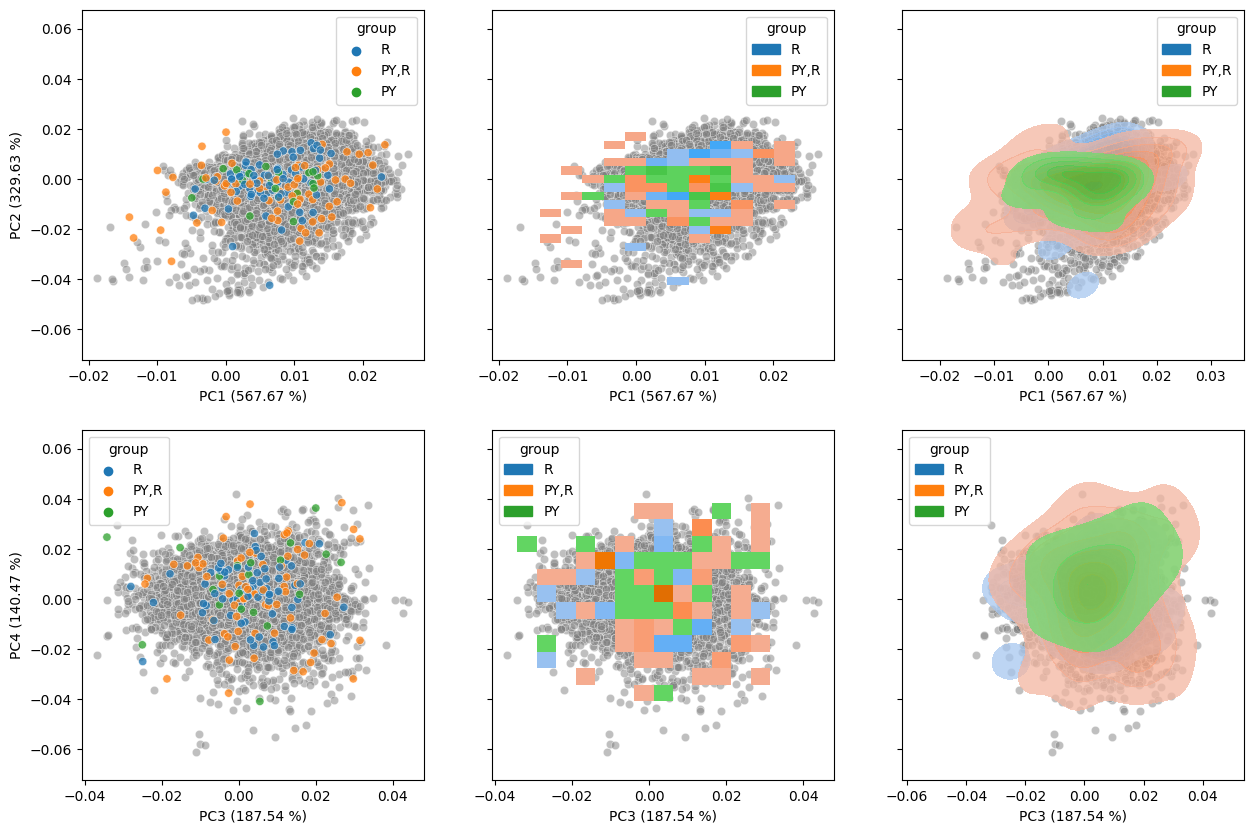

In [28]:
d = pd.DataFrame.from_dict({
    "PC1": pca.components_[0], 
    "PC2": pca.components_[1],
    "PC3": pca.components_[2], 
    "PC4": pca.components_[3],
    "group": adata.var.group
})


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, ncols=3, figsize=(15, 10), sharex=False, sharey=True)
# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC1", y="PC2", ax=ax1, alpha=0.5, color="grey")
sns.scatterplot(d[d["group"] != background_genes_key], x="PC1", y="PC2", hue="group",  ax=ax1, alpha=0.75)
ax1.set_xlabel("PC1 (%.2f %%)" % (pca.explained_variance_[0]))
ax1.set_ylabel("PC2 (%.2f %%)" % (pca.explained_variance_[1]))

# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC1", y="PC2", ax=ax2, alpha=0.5, color="grey")
sns.histplot(d[d["group"] != background_genes_key], x="PC1", y="PC2", hue="group", ax=ax2)
ax2.set_xlabel("PC1 (%.2f %%)" % (pca.explained_variance_[0]))

# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC1", y="PC2", ax=ax3, alpha=0.5, color="grey")
sns.kdeplot(d[d["group"] != background_genes_key], x="PC1", y="PC2", hue="group", ax=ax3, fill=True, alpha=0.75)
ax3.set_xlabel("PC1 (%.2f %%)" % (pca.explained_variance_[0]))

# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC3", y="PC4", ax=ax4, alpha=0.5, color="grey")
sns.scatterplot(d[d["group"] != background_genes_key], x="PC3", y="PC4", hue="group",  ax=ax4, alpha=0.75)
ax4.set_xlabel("PC3 (%.2f %%)" % (pca.explained_variance_[2]))
ax4.set_ylabel("PC4 (%.2f %%)" % (pca.explained_variance_[3]))

# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC3", y="PC4", ax=ax5, alpha=0.5, color="grey")
sns.histplot(d[d["group"] != background_genes_key], x="PC3", y="PC4", hue="group", ax=ax5)
ax5.set_xlabel("PC3 (%.2f %%)" % (pca.explained_variance_[2]))

# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC3", y="PC4", ax=ax6, alpha=0.5, color="grey")
sns.kdeplot(d[d["group"] != background_genes_key], x="PC3", y="PC4", hue="group", ax=ax6, fill=True, alpha=0.75)
ax6.set_xlabel("PC3 (%.2f %%)" % (pca.explained_variance_[2]))
